In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy
import matplotlib

import numpy as np
import pandas as pd

from scipy.signal import find_peaks

from pygama.flow import DataLoader
from pygama.flow import FileDB
from pygama.lgdo import Array
from pygama.lgdo import Struct
from pygama.lgdo import LH5Store
from pygama.math import histogram as pgh

In [ ]:
fdb = FileDB(config="../processing/metadata/dataloader_configs/cage_filedb_config.json", scan=True)
fdb.scan_tables_columns()
fdb.to_disk("../processing/cage_filedb.lh5", "o")

In [2]:
fdb = FileDB("../processing/cage_filedb.lh5")

In [3]:
dl = DataLoader(config="../processing/metadata/dataloader_configs/cage_loader_config.json",
                filedb=fdb)

In [4]:
dl.reset()
dl.set_files(f"cycle in [3207, 3208] ")
dl.set_output(merge_files=True, columns=["trapEftp", "dcr"])
test = dl.load()

Building entry list: 100%|██████████| 2/2 [00:00<00:00, 22.54 keys/s, key=3208]  

In [55]:
def get_runtime(data):
    if 'timestamp' not in data.keys():
        return np.sum([get_runtime(data[key]) for key in data.keys()])
    # correct for timestamp rollover
    clock = 100e6 # 100 MHz
    UINT_MAX = 4294967295 # (0xffffffff)
    t_max = UINT_MAX / clock


    ts = data['timestamp'].nda / clock # converts to float

    tdiff = np.diff(ts)
    tdiff = np.insert(tdiff, 0 , 0)
    iwrap = np.where(tdiff < 0)
    iloop = np.append(iwrap[0], len(ts))

    ts_new, t_roll = [], 0
    for i, idx in enumerate(iloop):
        ilo = 0 if i==0 else iwrap[0][i-1]
        ihi = idx
        ts_block = ts[ilo:ihi]
        t_last = ts[ilo-1]
        t_diff = t_max - t_last
        ts_new.append(ts_block + t_roll)
        t_roll += t_last + t_diff
    ts_corr = np.concatenate(ts_new)

    # calculate runtime and unix stopTime
    rt = ts_corr[-1] / 60 # minutes

    return rt 

def calibrate_energy(energy, ebins):
    hist, _ = np.histogram(energy, ebins)
    half = int(len(ebins)/2)
    k40_peak = ebins[np.argmax(hist[half:]) + half]
    return energy*1460.8/k40_peak



ebins = np.linspace(0, 6000, 1000)
cal_ebins = np.linspace(0, 4000, 2000)
dcr_bins = np.arange(-100, 200)
tp20_bins = np.arange(0, 1500, 10)
tp90_bins = np.arange(0, 1500, 10)
toe_bins = np.linspace(0, 1, 1000)
lt_bins = np.linspace(-2.5e-4, -0.5e-4, 1000)

In [6]:
sto = LH5Store()

In [ ]:
dl.reset()
dl.set_files(f"run in [433, 471]")
dl.set_output(merge_files=False, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "lt_slope"])
bkg = dl.load()
sto.write_object(bkg, "bkg", "icpc_scan_data.lh5")

In [7]:
bkg, _ = sto.read_object("bkg", "icpc_scan_data.lh5")

In [56]:
bkg_runtime = get_runtime(bkg)
print(bkg_runtime)
for file in bkg.keys():
    bkg[file]['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(bkg[file]['trapEmax_ctc'].nda, ebins))

1346.6143777643333


In [57]:
cal_bkg_hist = None
for file in bkg.keys():
    if cal_bkg_hist is None:
        cal_bkg_hist, _ = np.histogram(bkg[file]['cal_trapEmax_ctc'].nda, bins=cal_ebins)
    else:
        cal_bkg_hist += np.histogram(bkg[file]['cal_trapEmax_ctc'].nda, bins=cal_ebins)[0]

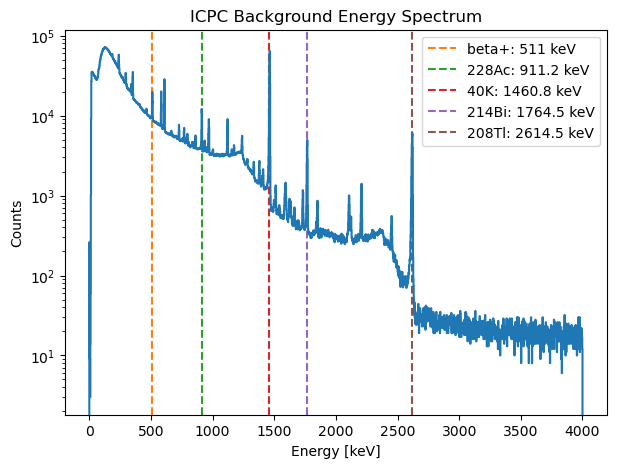

In [58]:
plt.figure(figsize=(7, 5))

peaks = {
    'beta+': 511, 
    '228Ac': 911.2, 
    '40K': 1460.8, 
    '214Bi': 1764.5, 
    '208Tl': 2614.5
}
i = 1
for p, e in peaks.items():
    plt.axvline(e, label=f'{p}: {e} keV', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], linestyle='dashed')
    i += 1

pgh.plot_hist(cal_bkg_hist, bins=cal_ebins)
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.title('ICPC Background Energy Spectrum')
plt.legend(loc='upper right')

In [59]:
idx = []
for v in peaks.values():
    idx.append(np.abs(cal_ebins - v).argmin())
print(cal_ebins[idx])
    
peak_loc = np.array([])

for i in idx:
    peak_loc = np.append(peak_loc, np.array(cal_ebins[i - 10 + cal_bkg_hist[i-10:i+10].argmax()]))

print(peak_loc)

[ 510.25512756  910.45522761 1460.73036518 1764.88244122 2615.30765383]
[ 510.25512756  910.45522761 1462.73136568 1766.88344172 2619.30965483]


(-5.0, 5.0)

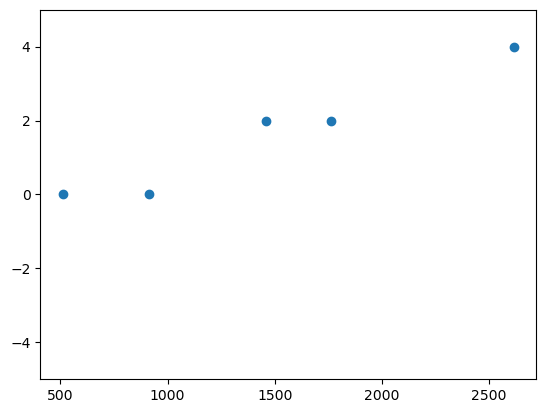

In [62]:
plt.scatter(peaks.values(), peak_loc - cal_ebins[idx])
plt.ylim((-5, 5))

In [12]:
dcr_bkg_hist = None
for file in bkg.keys():
    if dcr_bkg_hist is None:
        dcr_bkg_hist, _, _ = np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['dcr'].nda, bins=(cal_ebins, dcr_bins))
    else:
        dcr_bkg_hist += np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['dcr'].nda, bins=(cal_ebins, dcr_bins))[0]

In [10]:
tp020_bkg_hist = None
tp1090_bkg_hist = None
for file in bkg.keys():
    bkg[file]['tp0_20'] = Array(nda = (bkg[file]['tp_20'].nda - bkg[file]['tp_0'].nda) )
    bkg[file]['tp10_90'] = Array(nda = (bkg[file]['tp_90'].nda - bkg[file]['tp_10'].nda) )
    if tp020_bkg_hist is None:
        tp020_bkg_hist = np.histogram(bkg[file]['tp0_20'].nda, bins=tp20_bins)[0]
    else:
        tp020_bkg_hist += np.histogram(bkg[file]['tp0_20'].nda, bins=tp20_bins)[0]
        
    if tp1090_bkg_hist is None:
        tp1090_bkg_hist = np.histogram(bkg[file]['tp10_90'].nda, bins=tp90_bins)[0]
    else:
        tp1090_bkg_hist += np.histogram(bkg[file]['tp10_90'].nda, bins=tp90_bins)[0]

In [11]:
tp020_energy_bkg_hist = None
tp1090_energy_bkg_hist = None
for file in bkg.keys():
    if tp020_energy_bkg_hist is None:
        tp020_energy_bkg_hist = np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['tp0_20'].nda, bins=(cal_ebins, tp20_bins))[0]
    else:
        tp020_energy_bkg_hist += np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['tp0_20'].nda, bins=(cal_ebins, tp20_bins))[0]
    
    if tp1090_energy_bkg_hist is None:
        tp1090_energy_bkg_hist = np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['tp10_90'].nda, bins=(cal_ebins, tp90_bins))[0]
    else:
        tp1090_energy_bkg_hist += np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['tp10_90'].nda, bins=(cal_ebins, tp90_bins))[0]


In [12]:
toe_bkg_hist = None
for file in bkg.keys():
    if toe_bkg_hist is None:
        toe_bkg_hist = np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['ToE'].nda, bins=(cal_ebins, toe_bins))[0]
    else:
        toe_bkg_hist += np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['ToE'].nda, bins=(cal_ebins, toe_bins))[0]


In [13]:
lt_bkg_hist = None
for file in bkg.keys():
    if lt_bkg_hist is None:
        lt_bkg_hist = np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['lt_slope'].nda, bins=(cal_ebins, lt_bins))[0]
    else:
        lt_bkg_hist += np.histogram2d(bkg[file]['cal_trapEmax_ctc'].nda, bkg[file]['lt_slope'].nda, bins=(cal_ebins, lt_bins))[0]


In [8]:
alp_runs = np.arange(434, 471)
alp = {}
alp_data = Struct(attrs={'keys_dtype': 'int'})
for r in alp_runs:
    alp[r] = {'rt': 0,
              'cal_hist': None}

In [ ]:
# Run to load data and save to file
for run in alp_runs:
    dl.reset()
    dl.set_files(f"run == {run}")
    dl.set_output(merge_files=False, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "lt_slope"])
    data = dl.load()
    alp_data[run] = data
    
    alp[run]['rt'] = get_runtime(data) 
    for file in data.keys():
        data[file]['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(data[file]['trapEmax_ctc'].nda, ebins))
        data[file]['tp0_20'] = Array(nda= (data[file]['tp_20'].nda - data[file]['tp_0'].nda) )
        data[file]['tp10_90'] = Array(nda= (data[file]['tp_90'].nda - data[file]['tp_10'].nda) )
    
    cal_data_hist = None
    for file in data.keys():
        if cal_data_hist is None:
            cal_data_hist, _ = np.histogram(data[file]['cal_trapEmax_ctc'].nda, bins=cal_ebins)
        else:
            cal_data_hist += np.histogram(data[file]['cal_trapEmax_ctc'].nda, bins=cal_ebins)[0]
    alp[run]['cal_hist'] = cal_data_hist
    
    dcr_data_hist = None
    for file in data.keys():
        if dcr_data_hist is None:
            dcr_data_hist, _, _ = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['dcr'].nda, bins=(cal_ebins, dcr_bins))
        else:
            dcr_data_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['dcr'].nda, bins=(cal_ebins, dcr_bins))[0]
    alp[run]['dcr_hist'] = dcr_data_hist
    
    alp[run]['subbed_energy_hist'] = alp[run]['cal_hist']/alp[run]['rt'] - cal_bkg_hist/bkg_runtime
    alp[run]['subbed_energy_unc'] = np.sqrt(alp[run]['cal_hist'])/alp[run]['rt'] - np.sqrt(cal_bkg_hist)/bkg_runtime
    
    tp020_hist = None
    for file in data.keys():
        if tp020_hist is None:
            tp020_hist = np.histogram(data[file]['tp0_20'].nda, bins=tp20_bins)[0]
        else:
            tp020_hist += np.histogram(data[file]['tp0_20'].nda, bins=tp20_bins)[0]
    alp[run]['tp020_hist'] = tp020_hist

    tp1090_hist = None
    for file in data.keys():
        if tp1090_hist is None:
            tp1090_hist = np.histogram(data[file]['tp10_90'].nda, bins=tp90_bins)[0]
        else:
            tp1090_hist += np.histogram(data[file]['tp10_90'].nda, bins=tp90_bins)[0]
    alp[run]['tp1090_hist'] = tp1090_hist
    
    tp20_energy_hist = None
    for file in data.keys():
        if tp20_energy_hist is None:
            tp20_energy_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp0_20'].nda, bins=(cal_ebins, tp20_bins))[0]
        else:
            tp20_energy_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp0_20'].nda, bins=(cal_ebins, tp20_bins))[0]
    alp[run]['tp20_energy_hist'] = tp20_energy_hist
    
    tp90_energy_hist = None
    for file in data.keys():
        if tp90_energy_hist is None:
            tp90_energy_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp10_90'].nda, bins=(cal_ebins, tp90_bins))[0]
        else:
            tp90_energy_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp10_90'].nda, bins=(cal_ebins, tp90_bins))[0]
    alp[run]['tp90_energy_hist'] = tp90_energy_hist
    
    toe_hist = None
    for file in data.keys():
        if toe_hist is None:
            toe_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['ToE'].nda, bins=(cal_ebins, toe_bins))[0]
        else:
            toe_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['ToE'].nda, bins=(cal_ebins, toe_bins))[0]
    alp[run]['toe_hist'] = toe_hist
    
    lt_hist = None
    for file in data.keys():
        if lt_hist is None:
            lt_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['lt_slope'].nda, bins=(cal_ebins, lt_bins))[0]
        else:
            lt_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['lt_slope'].nda, bins=(cal_ebins, lt_bins))[0]
    alp[run]['lt_hist'] = lt_hist
alp_data.update_datatype()
sto.write_object(alp_data, "alp", "icpc_scan_data.lh5", wo_mode="o")

In [23]:
# Run to use already saved data and remake histograms
alp_data, _ = sto.read_object("alp", "icpc_scan_data.lh5")

for run in alp_runs:
    data = alp_data[run]
    
    alp[run]['rt'] = get_runtime(data) 
    for file in data.keys():
        data[file]['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(data[file]['trapEmax_ctc'].nda, ebins))
        data[file]['tp0_20'] = Array(nda= (data[file]['tp_20'].nda - data[file]['tp_0'].nda) )
        data[file]['tp10_90'] = Array(nda= (data[file]['tp_90'].nda - data[file]['tp_10'].nda) )
    
    cal_data_hist = None
    for file in data.keys():
        if cal_data_hist is None:
            cal_data_hist, _ = np.histogram(data[file]['cal_trapEmax_ctc'].nda, bins=cal_ebins)
        else:
            cal_data_hist += np.histogram(data[file]['cal_trapEmax_ctc'].nda, bins=cal_ebins)[0]
    alp[run]['cal_hist'] = cal_data_hist
    
    dcr_data_hist = None
    for file in data.keys():
        if dcr_data_hist is None:
            dcr_data_hist, _, _ = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['dcr'].nda, bins=(cal_ebins, dcr_bins))
        else:
            dcr_data_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['dcr'].nda, bins=(cal_ebins, dcr_bins))[0]
    alp[run]['dcr_hist'] = dcr_data_hist
    
    alp[run]['subbed_energy_hist'] = alp[run]['cal_hist']/alp[run]['rt'] - cal_bkg_hist/bkg_runtime
    alp[run]['subbed_energy_unc'] = np.sqrt(alp[run]['cal_hist'])/alp[run]['rt'] - np.sqrt(cal_bkg_hist)/bkg_runtime
    
    tp020_hist = None
    for file in data.keys():
        if tp020_hist is None:
            tp020_hist = np.histogram(data[file]['tp0_20'].nda, bins=tp20_bins)[0]
        else:
            tp020_hist += np.histogram(data[file]['tp0_20'].nda, bins=tp20_bins)[0]
    alp[run]['tp020_hist'] = tp020_hist

    tp1090_hist = None
    for file in data.keys():
        if tp1090_hist is None:
            tp1090_hist = np.histogram(data[file]['tp10_90'].nda, bins=tp90_bins)[0]
        else:
            tp1090_hist += np.histogram(data[file]['tp10_90'].nda, bins=tp90_bins)[0]
    alp[run]['tp1090_hist'] = tp1090_hist
    
    tp20_energy_hist = None
    for file in data.keys():
        if tp20_energy_hist is None:
            tp20_energy_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp0_20'].nda, bins=(cal_ebins, tp20_bins))[0]
        else:
            tp20_energy_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp0_20'].nda, bins=(cal_ebins, tp20_bins))[0]
    alp[run]['tp20_energy_hist'] = tp20_energy_hist
    
    tp90_energy_hist = None
    for file in data.keys():
        if tp90_energy_hist is None:
            tp90_energy_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp10_90'].nda, bins=(cal_ebins, tp90_bins))[0]
        else:
            tp90_energy_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['tp10_90'].nda, bins=(cal_ebins, tp90_bins))[0]
    alp[run]['tp90_energy_hist'] = tp90_energy_hist
    
    toe_hist = None
    for file in data.keys():
        if toe_hist is None:
            toe_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['ToE'].nda, bins=(cal_ebins, toe_bins))[0]
        else:
            toe_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['ToE'].nda, bins=(cal_ebins, toe_bins))[0]
    alp[run]['toe_hist'] = toe_hist
    
    lt_hist = None
    for file in data.keys():
        if lt_hist is None:
            lt_hist = np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['lt_slope'].nda, bins=(cal_ebins, lt_bins))[0]
        else:
            lt_hist += np.histogram2d(data[file]['cal_trapEmax_ctc'].nda, data[file]['lt_slope'].nda, bins=(cal_ebins, lt_bins))[0]
    alp[run]['lt_hist'] = lt_hist

NameError: name 'cal_bkg_hist' is not defined

In [20]:
rot0 = np.arange(458, 471)
rot180 = [458, 457, 456, 455, 442, 441,440, 439, 438, 437, 436, 435, 434]
rot145 = [458, 454, 453, 452, 451, 450, 449, 448, 447, 446, 445, 444, 443]

rot = {
    0: rot0,
    145: rot145,
    180: rot180
}

linrange = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]

In [17]:
hists = {
    "dcr": {
        "alp_name": "dcr_hist",
        "bkg": dcr_bkg_hist,
        "bins": dcr_bins,
        "title": "DCR"
    },
    "ToE": {
        "alp_name": "toe_hist",
        "bkg": toe_bkg_hist,
        "bins": toe_bins,
        "title": "ToE"
    },
    "tp020": {
        "alp_name": "tp20_energy_hist",
        "bkg": tp020_energy_bkg_hist,
        "bins": tp20_bins,
        "title": "tp20-tp0"
    },
    "tp1090": {
        "alp_name": "tp90_energy_hist",
        "bkg": tp1090_energy_bkg_hist,
        "bins": tp90_bins,
        "title": "tp90-tp10"
    },
    "lt": {
        "alp_name": "lt_hist",
        "bkg": lt_bkg_hist,
        "bins": lt_bins,
        "title": "Log-Tail Slope"
    }
}

def plot_subbed_hist_by_run(r, var, cuts=None, save=False):
    """
    r: int, rotary angle (0, 145, or 180)
    var: str, key in hists above
    cuts: tuple of array-likes, plt.plot(cuts[0], cuts[1])
    save: save figures in plots folder
    """
    cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))
    cmap.set_bad((1,1,1))
    for i, run in enumerate(rot[r]):
        plt.figure()
        plt.pcolor(cal_ebins, hists[var]['bins'], 
                   alp[run][hists[var]['alp_name']].T/alp[run]['rt']-hists[var]['bkg'].T/bkg_runtime, 
                   norm=colors.LogNorm(vmin=1e-3, vmax=5), cmap=cmap)
        if cuts:
            plt.plot(cuts[0], cuts[1], color='r')
        plt.title(f"{hists[var]['title']} vs Energy Rotary {r} - Linear {linrange[i]}")
        plt.colorbar()
        if save:
            plt.savefig(f"plots/{var}_rot{r}_linear{linrange[i]}.png")

In [24]:
# cuts = (cal_ebins[1:], 60*np.log(cal_ebins[1:])) #tp1090
cuts = None
plot_subbed_hist_by_run(180, "dcr", cuts, save=False)

/tmp/ipykernel_35747/3181300962.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))


KeyError: 'dcr_hist'

<Figure size 640x480 with 0 Axes>

In [139]:
alp_dfs = {}
for run in alp_runs:
    run_df = None
    data = alp_data[run]
    file_dfs = [data[file].get_dataframe() for file in data.keys()]
    run_df = pd.concat(file_dfs, ignore_index=True)
    alp_dfs[run] = run_df

In [166]:
cut_dfs = {}
full_cut = " (cal_trapEmax_ctc > -35000*(ToE - 0.5)**2 + 1300) and ((tp_20 - tp_0) < 60*log(cal_trapEmax_ctc-500)-150)"
for r in alp_dfs.keys():
    cut_dfs[r] = alp_dfs[r].query(full_cut)

bkg_cut_df = bkg_df.query(full_cut)

In [177]:
from tqdm.notebook import tqdm

In [178]:
pars = {
    "dcr": dcr_bins,
    "ToE": toe_bins,
    "tp0_20": tp20_bins,
    "tp10_90": tp90_bins
}

subbed_cut_hists = {}
for i in tqdm(range(len(alp_runs))):
    run = alp_runs[i]
    subbed_cut_hists[run] = {}
    for par in pars:
        subbed_cut_hists[run][par] = np.histogram2d(cut_dfs[run]['cal_trapEmax_ctc'], cut_dfs[run][par],
                                                    bins=(cal_ebins, pars[par]))[0]/alp[run]['rt'] - np.histogram2d(bkg_df['cal_trapEmax_ctc'], bkg_df[par],
                                                    bins=(cal_ebins, pars[par]))[0]/bkg_runtime

  0%|          | 0/37 [00:00<?, ?it/s]

In [192]:
alp_count = [[],[],[]]

for r in rot0:
    alp_count[0].append(np.sum(subbed_cut_hists[r]['dcr'], where=(subbed_cut_hists[r]['dcr'] > 0)))
                        
for r in rot145:
    alp_count[1].append(np.sum(subbed_cut_hists[r]['dcr'], where=(subbed_cut_hists[r]['dcr'] > 0)))
                        
for r in rot180:
    alp_count[2].append(np.sum(subbed_cut_hists[r]['dcr'], where=(subbed_cut_hists[r]['dcr'] > 0)))


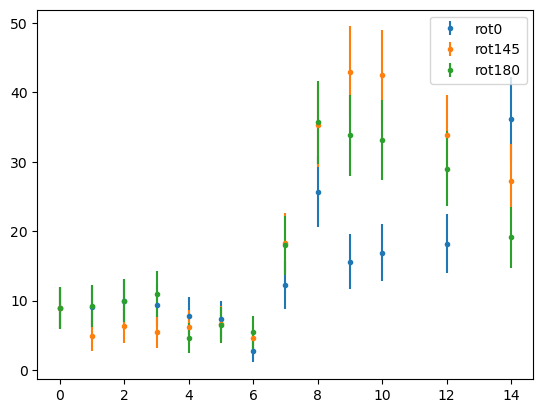

In [194]:
rots = [0, 145, 180]
for i in range(len(alp_count)):
    plt.errorbar(linrange, alp_count[i], yerr=np.sqrt(alp_count[i]), fmt='.', label=f"rot{rots[i]}")
plt.legend()

In [206]:
import gc
gc.collect()

6635299

In [ ]:
par = 'dcr'
for i, run in enumerate(rot0):
    plt.figure()
    plt.pcolor(cal_ebins, pars[par], subbed_cut_hists[run][par].T,
              norm=colors.LogNorm(vmin=1e-6, vmax=1e-1))
    plt.colorbar()
    plt.title(f"Rotary 0 Linear {linrange[i]} - Cut + Bkg-Sub")
    plt.xlabel("Energy")
    plt.ylabel(par)
    plt.savefig(f'plots/cut_{par}_rot0_linear{linrange[i]}.png')

## Looking at Alpha Waveforms

In [5]:
dl.reset()
dl.set_files(f"run == 446")
dl.set_cuts({"hit": "(trapEmax_ctc/0.7 > -35000*(ToE - 0.5)**2 + 1300) and ((tp_20 - tp_0) < 60*log(trapEmax_ctc/0.7-500)-150)"})
dl.set_output(merge_files=True, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "tp_50", "waveform"])
rot145_lin9_alp = dl.load()
rot145_lin9_alp['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(rot145_lin9_alp['trapEmax_ctc'].nda, ebins))

Building entry list: 100%|██████████| 9/9 [00:03<00:00,  2.99 keys/s, key=3471]  


NameError: name 'calibrate_energy' is not defined

In [7]:
rot145_lin9_alp['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(rot145_lin9_alp['trapEmax_ctc'].nda, ebins))

In [8]:
dl.reset()
dl.set_files(f"run == 443")
dl.set_cuts({"hit": "ToE < 0.8 and ToE > 0.65 and (tp_90 - tp_10) < 200"})
dl.set_output(merge_files=True, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "tp_50", "waveform"])
rot145_lin14_ToE_alp = dl.load()
rot145_lin14_ToE_alp['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(rot145_lin14_ToE_alp['trapEmax_ctc'].nda, ebins))

Building entry list: 100%|██████████| 13/13 [00:03<00:00,  3.27 keys/s, key=3408] 


In [9]:
dl.reset()
dl.set_files(f"run == 436")
dl.set_cuts({"hit": "ToE < 0.8 and ToE > 0.6 and trapEmax_ctc > 1500/0.7"})
dl.set_output(merge_files=True, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "tp_50", "waveform"])
rot180_lin10_ToE_alp = dl.load()
rot180_lin10_ToE_alp['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(rot180_lin10_ToE_alp['trapEmax_ctc'].nda, ebins))

Building entry list: 100%|██████████| 8/8 [00:01<00:00,  4.62 keys/s, key=3281]  

In [10]:
dl.reset()
dl.set_files(f"run == 448")
dl.set_cuts({"hit": "abs(ToE - (3e-4*trapEmax_ctc*0.7304 + 0.05) ) < 0.05 and trapEmax_ctc < 500/0.7304"})
dl.set_output(merge_files=True, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "tp_50", "waveform"])
rot145_lin7_ToE_alp = dl.load()
rot145_lin7_ToE_alp['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(rot145_lin7_ToE_alp['trapEmax_ctc'].nda, ebins))

Building entry list: 100%|██████████| 9/9 [00:01<00:00,  4.88 keys/s, key=3491]  

In [11]:
dl.reset()
dl.set_files(f"cycle == 3865")
dl.set_cuts({"hit": "abs(ToE - 0.5) < 0.05 and abs(dcr) < 1"})
dl.set_output(merge_files=True, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "tp_50", "waveform"])

bulk_el = dl.build_entry_list(save_output_columns=True)

Building entry list: 100%|██████████| 1/1 [00:00<00:00, 2966.27 keys/s, key=3865]

In [12]:
bulk = dl.load(bulk_el)
bulk['cal_trapEmax_ctc'] = Array(nda=calibrate_energy(bulk['trapEmax_ctc'].nda, ebins))

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

blue_cmap = truncate_colormap(plt.get_cmap('Blues'), 0, 0.5)
red_cmap = truncate_colormap(plt.get_cmap('Reds'), 0, 0.5)
orange_cmap = truncate_colormap(plt.get_cmap('Oranges'), 0, 0.5)
green_cmap = truncate_colormap(plt.get_cmap('Greens'), 0, 0.5)
purple_cmap = truncate_colormap(plt.get_cmap('Purples'), 0, 0.5)

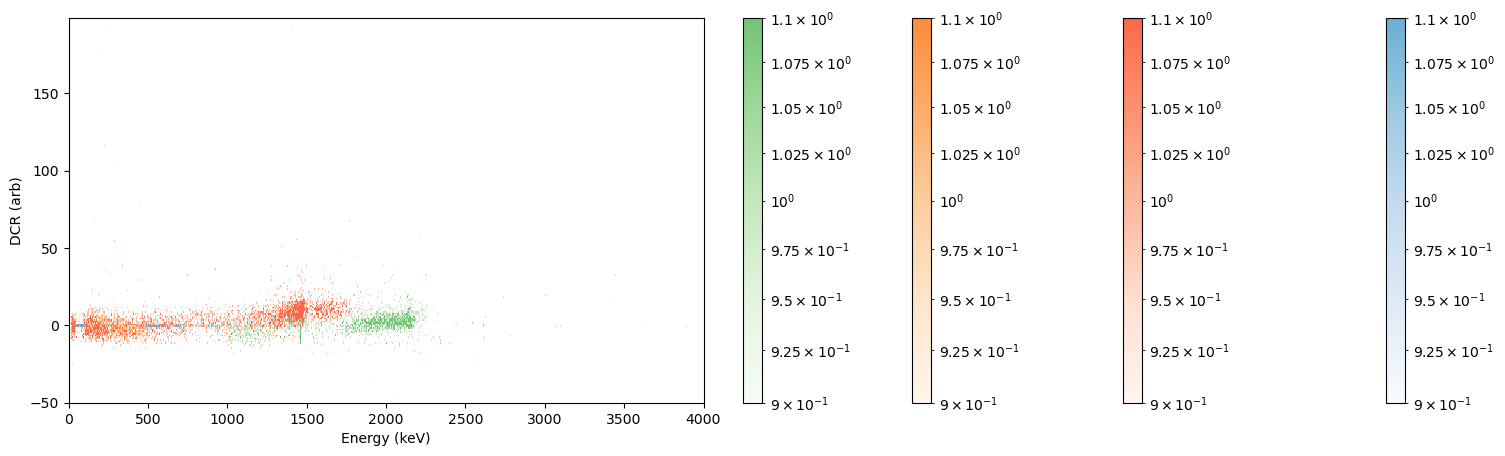

In [112]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
bulk_hist = plt.hist2d(x=bulk['cal_trapEmax_ctc'].nda, y=bulk['dcr'].nda,
          bins=(cal_ebins, dcr_bins), cmap=blue_cmap, norm=colors.LogNorm(vmax=1), label='bulk')
seagull_hist = plt.hist2d(x=rot145_lin14_ToE_alp['cal_trapEmax_ctc'].nda, y=rot145_lin14_ToE_alp['dcr'].nda,
          bins=(cal_ebins, dcr_bins), cmap=red_cmap, norm=colors.LogNorm(vmax=1), label='seagull')
lowE_hist = plt.hist2d(x=rot145_lin7_ToE_alp['cal_trapEmax_ctc'].nda, y=rot145_lin7_ToE_alp['dcr'].nda,
          bins=(cal_ebins, dcr_bins), cmap=orange_cmap, norm=colors.LogNorm(vmax=1), label='lowE')
roi_hist = plt.hist2d(x=rot180_lin10_ToE_alp['cal_trapEmax_ctc'].nda, y=rot180_lin10_ToE_alp['dcr'].nda,
          bins=(cal_ebins, dcr_bins), cmap=green_cmap, norm=colors.LogNorm(vmax=1), label='RoI')
plt.colorbar(bulk_hist[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(seagull_hist[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(lowE_hist[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(roi_hist[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.xlabel('Energy (keV)')
plt.ylabel('DCR (arb)')
plt.show()

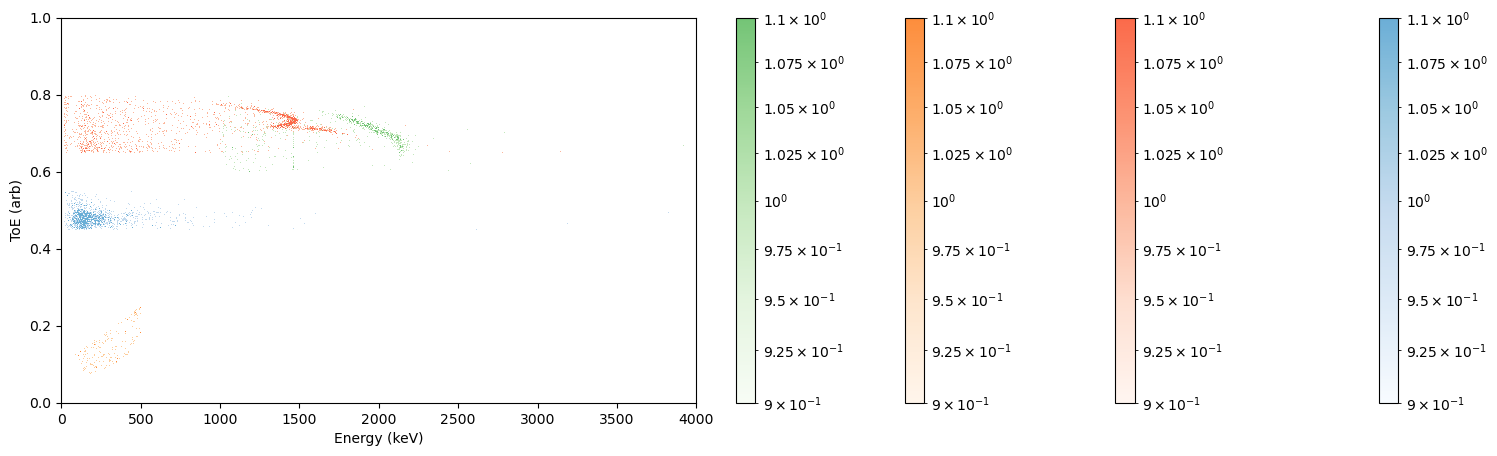

In [113]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
bulk_hist_toe = plt.hist2d(x=bulk['cal_trapEmax_ctc'].nda, y=bulk['ToE'].nda,
          bins=(cal_ebins, toe_bins), cmap=blue_cmap, norm=colors.LogNorm(vmax=1), label='bulk')
seagull_hist_toe = plt.hist2d(x=rot145_lin14_ToE_alp['cal_trapEmax_ctc'].nda, y=rot145_lin14_ToE_alp['ToE'].nda,
          bins=(cal_ebins, toe_bins), cmap=red_cmap, norm=colors.LogNorm(vmax=1), label='seagull')
lowE_hist_toe = plt.hist2d(x=rot145_lin7_ToE_alp['cal_trapEmax_ctc'].nda, y=rot145_lin7_ToE_alp['ToE'].nda,
          bins=(cal_ebins, toe_bins), cmap=orange_cmap, norm=colors.LogNorm(vmax=1), label='lowE')
roi_hist_toe = plt.hist2d(x=rot180_lin10_ToE_alp['cal_trapEmax_ctc'].nda, y=rot180_lin10_ToE_alp['ToE'].nda,
          bins=(cal_ebins, toe_bins), cmap=green_cmap, norm=colors.LogNorm(vmax=1), label='RoI')
plt.colorbar(bulk_hist_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(seagull_hist_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(lowE_hist_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(roi_hist_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.xlabel('Energy (keV)')
plt.ylabel('ToE (arb)')
plt.show()

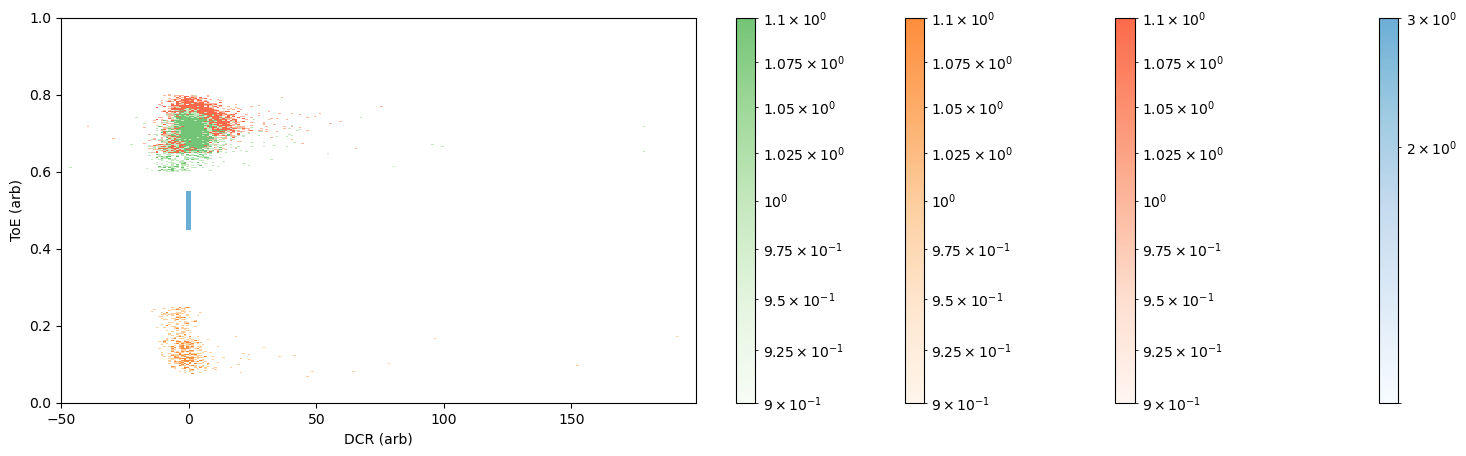

In [114]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
bulk_hist_dcr_toe = plt.hist2d(x=bulk['dcr'].nda, y=bulk['ToE'].nda,
          bins=(dcr_bins, toe_bins), cmap=blue_cmap, norm=colors.LogNorm(vmax=1), label='bulk')
seagull_hist_dcr_toe = plt.hist2d(x=rot145_lin14_ToE_alp['dcr'].nda, y=rot145_lin14_ToE_alp['ToE'].nda,
          bins=(dcr_bins, toe_bins), cmap=red_cmap, norm=colors.LogNorm(vmax=1), label='seagull')
lowE_hist_dcr_toe = plt.hist2d(x=rot145_lin7_ToE_alp['dcr'].nda, y=rot145_lin7_ToE_alp['ToE'].nda,
          bins=(dcr_bins, toe_bins), cmap=orange_cmap, norm=colors.LogNorm(vmax=1), label='lowE')
roi_hist_dcr_toe = plt.hist2d(x=rot180_lin10_ToE_alp['dcr'].nda, y=rot180_lin10_ToE_alp['ToE'].nda,
          bins=(dcr_bins, toe_bins), cmap=green_cmap, norm=colors.LogNorm(vmax=1), label='RoI')
plt.colorbar(bulk_hist_dcr_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(seagull_hist_dcr_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(lowE_hist_dcr_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.colorbar(roi_hist_dcr_toe[3], orientation='vertical', ticks=matplotlib.ticker.FixedLocator([]))
plt.ylabel('ToE (arb)')
plt.xlabel('DCR (arb)')
plt.show()

In [29]:
def super_wf(data):
    super_alp = None
    alp_count = 0
    for i, wf in enumerate(data['waveform']['values'].nda):
        samp50 = int(data['tp_50'].nda[i]/10)
        if samp50 < 2000 or samp50 > 6000:
            continue
        centered = wf[samp50-2000:samp50+2000]
        if np.max(centered > 14000):
            continue
        if super_alp is None:
            super_alp = np.array((centered - np.min(centered))/(np.max(centered) - np.min(centered)))
        else:
            super_alp += np.array((centered - np.min(centered))/(np.max(centered) - np.min(centered)))
        alp_count += 1
    super_alp /= alp_count
    return super_alp


In [30]:
bulk_super = super_wf(bulk)
seagull_super = super_wf(rot145_lin14_ToE_alp)
lowE_super = super_wf(rot145_lin7_ToE_alp)
roi_super = super_wf(rot180_lin10_ToE_alp)
alp_super = super_wf(rot145_lin9_alp)

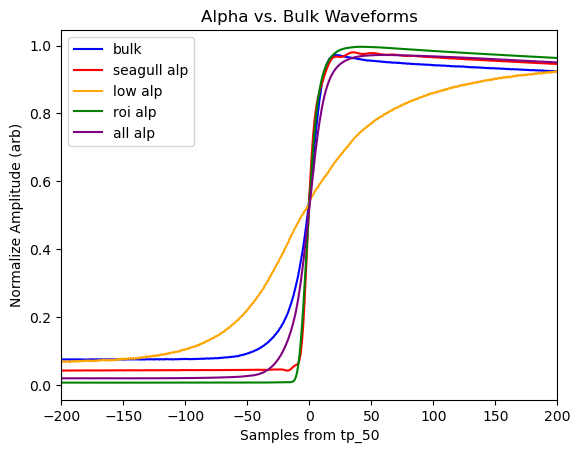

In [34]:
plt.plot(np.arange(-2000, 2000), bulk_super, label='bulk', color='b')
plt.plot(np.arange(-2000, 2000), seagull_super, label='seagull alp', color='r')
plt.plot(np.arange(-2000, 2000), lowE_super, label='low alp', color='orange')
plt.plot(np.arange(-2000, 2000), roi_super, label='roi alp', color='g')
plt.plot(np.arange(-2000, 2000), alp_super, label='all alp', color='purple')
plt.legend()
plt.title("Alpha vs. Bulk Waveforms")
plt.xlim(-200, 200)
plt.ylabel('Normalize Amplitude (arb)')
plt.xlabel('Samples from tp_50')
plt.savefig('plots/super_pulse.png')

In [ ]:
pgh.plot_hist(cal_bkg_hist/bkg_runtime, cal_ebins, label="bkg")
for run in alp_runs:
    pgh.plot_hist(alp[run]['cal_hist']/alp[run]['rt'], cal_ebins, label=run)
plt.yscale('log')
plt.legend()

In [ ]:
plt.figure(figsize=(10,5))
for run in [455, 441]:
    pgh.plot_hist(alp[run]['subbed_hist'], cal_ebins, label=f"{run}")
plt.legend(loc="upper right")
#plt.yscale('log')
plt.xlim(40, 80)
#plt.ylim(0, 0.75)
plt.title("Background subtracted spectra")
plt.xlabel("Energy [keV]")
plt.ylabel("Counts [cts/min]")

In [ ]:
for run in alp_runs:
    gamma_bounds = np.where(np.abs(cal_ebins - 60) < 1.5)[0]
    alp[run]['gamma_count'] = alp[run]['subbed_hist'][gamma_bounds[0]-1]
    alp[run]['gamma_unc'] = alp[run]['subbed_unc'][gamma_bounds[0]-1]
    
    alpha_bounds = np.where(np.abs(cal_ebins - 2000) < 150)[0][[0, -1]]
    alp[run]['alp_count'] = np.sum(alp[run]['subbed_hist'][alpha_bounds[0]:alpha_bounds[1]])
    alp[run]['alp_unc'] = np.sqrt(np.sum(alp[run]['subbed_hist'][alpha_bounds[0]:alpha_bounds[1]]**2))

In [ ]:
#plt.figure(figsize=(10,10))
plt.errorbar(linrange, [alp[run]['gamma_count'] for run in rot0], 
             yerr=[alp[run]['gamma_unc'] for run in rot0], 
             fmt='.', label="rot0", color='b')
plt.errorbar(linrange, [alp[run]['gamma_count'] for run in rot180], 
             yerr=[alp[run]['gamma_unc'] for run in rot180], 
             fmt='.', label="rot180", color='red')
plt.errorbar(linrange, [alp[run]['gamma_count'] for run in rot145], 
             yerr=[alp[run]['gamma_unc'] for run in rot145], 
             fmt='.', label="rot145", color='lime')
plt.axvline(7.06, linestyle=(6, (2, 10)), color='b')
plt.axvline(6.47, linestyle=(0, (2, 10)), color='lime')
plt.axvline(7.06, linestyle=(0, (2, 10)), color='red')
plt.legend()
#plt.yscale('log')
#plt.xlim(1200, 4000)
plt.title("60 keV count")
plt.xlabel("Linear position")
plt.ylabel("Counts [cts/min]")

In [ ]:
#plt.figure(figsize=(10,10))
plt.errorbar(linrange, [alp[run]['alp_count'] for run in rot0], 
             yerr=[alp[run]['alp_unc'] for run in rot0], 
             fmt='.', label="rot0", color='b')
plt.errorbar(linrange, [alp[run]['alp_count'] for run in rot180], 
             yerr=[alp[run]['alp_unc'] for run in rot180], 
             fmt='.', label="rot180", color='red')
plt.errorbar(linrange, [alp[run]['alp_count'] for run in rot145], 
             yerr=[alp[run]['alp_unc'] for run in rot145], 
             fmt='.', label="rot145", color='lime')
plt.axvline(7.06, linestyle=(6, (2, 10)), color='b')
plt.axvline(6.47, linestyle=(0, (2, 10)), color='lime')
plt.axvline(7.06, linestyle=(0, (2, 10)), color='red')
plt.legend(loc="upper left")
#plt.yscale('log')
#plt.xlim(1200, 4000)
plt.title("Alpha count")
plt.xlabel("Linear Position")
plt.ylabel("Counts [cts/min]")

In [ ]:
for run in alp_runs:
    alp[run]['dcr_sub'] = alp[run]['dcr_hist']/alp[run]['rt'] - dcr_bkg_hist/bkg_runtime

In [ ]:
for i, run in enumerate(rot180[:]):
    #plt.figure(figsize=(10,5))
    plt.figure()
    plt.pcolor(cal_ebins, toe_bins, 
               alp[run]['toe_hist'].T/alp[run]['rt'], 
               norm=colors.LogNorm(vmin=1e-3))
    plt.title(f"ToE vs Energy Rotary 180 - Linear {linrange[i]}")
    toe_range = np.arange(0.2, 0.8, 0.1)
    plt.plot(-40000*(toe_range-0.5)**2 + 1000, toe_range, color='r')
    #plt.axhline(300, color='r')
    #plt.xlim(40, 80)
    #plt.ylim(0, 150)
    plt.colorbar()
    #plt.savefig(f"plots/toe_rot0_linear{linrange[i]}")


In [ ]:
for i, run in enumerate(rot180):
    #plt.figure(figsize=(10,5))
    plt.figure()
    plt.pcolor(cal_ebins, tp_bins, 
               alp[run]['tp_energy_hist'].T/alp[run]['rt'], 
               norm=colors.LogNorm(vmin=1e-3))
    plt.title(f"tp20-tp0 vs Energy Rotary 180 - Linear {linrange[i]}")
    plt.axhline(400, color='r')
    plt.plot(np.arange(750), 0.8*(np.arange(750) - 250), color='r')
    #plt.xlim(40, 80)
    #plt.ylim(0, 150)
    plt.colorbar()
    #plt.savefig(f"plots/tp_energy_rot0_linear{linrange[i]}")


In [ ]:
plt.figure(figsize=(10,5))
plt.pcolor(cal_ebins, dcr_bins, dcr_bkg_hist.T/bkg_runtime, norm=colors.LogNorm())
plt.title(f"DCR vs Energy - Background")
plt.colorbar()
for i, run in enumerate(rot145):
    plt.figure(figsize=(10,5))
    plt.pcolor(cal_ebins, dcr_bins, alp[run]['dcr_hist'].T/alp[run]['rt'], norm=colors.LogNorm())
    plt.title(f"DCR vs Energy Rotary 145 - Linear {linrange[i]}")
    plt.colorbar()
    plt.savefig(f"plots/dcr_rot145_linear{linrange[i]}")


In [ ]:
for i, run in enumerate([444]):
    plt.figure(figsize=(10,5))
    plt.pcolor(cal_ebins, dcr_bins, alp[run]['dcr_sub'].T, norm=colors.LogNorm(vmin=1e-5))
    plt.title(f"Bkg-Subtracted DCR vs Energy Rotary 145 - Linear {linrange[i]}")
    plt.colorbar()
    plt.xlabel("Energy (keV)")
    plt.ylabel("DCR (arb)")
    plt.axhline(10, color='r')
    plt.axvline(500, color='r')
    #plt.savefig(f"plots/dcr_rot145_linear{linrange[i]}.png")


In [ ]:
alp_dfs = {}

In [ ]:
for run in alp_runs:
    run_df = None
    data = alp_data[run]
    file_dfs = [data[file].get_dataframe() for file in data.keys()]
    run_df = pd.concat(file_dfs, ignore_index=True)
    alp_dfs[run] = run_df
    #for file in data.keys():
    #    file_df = data[file].get_dataframe()
    #    if run_df is None:
    #        run_df = file_df
    #    else:
    #        run_df = pd.concat((run_df, file_df), ignore_index=True)

In [ ]:
cut_dfs = {}
for run in alp_runs:
    cut_dfs[run] = alp_dfs[run].query("cal_trapEmax_ctc > -40000*(ToE-0.5)**2 + 1000 and lt_slope > -1.6e-4 and ( (cal_trapEmax_ctc < 750 and tp0_20 < 0.8*(cal_trapEmax_ctc - 250)) or (tp0_20 < 400) )")

In [ ]:
for run in rot145:
    plt.figure()
    plt.hist2d(cut_dfs[run]['cal_trapEmax_ctc'], cut_dfs[run]['dcr'], bins=(cal_ebins, dcr_bins), norm=colors.LogNorm())

In [ ]:
peaks = [238.6, 351.9, 583.2, 609.3, 911.2, 969.0, 1120.3, 1460.8, 1764.6, 2614.5]

In [ ]:
plt.bar(cal_ebins[:-1], cal_data_hist, width=np.diff(cal_ebins), align="edge")
plt.yscale('log')
plt.xlabel('trapEmax (rough cal)[kev]')
plt.ylabel('counts')
plt.title(f'Run {run}')
for pk in peaks:
    plt.axvspan(pk-1, pk+1, alpha = 0.3, color='red')

In [ ]:
pk_idx, _ = find_peaks(ectc_hist_cal)
energy_peaks = ectc_bins_cal[pk_idx]

In [ ]:
diffs = np.array([energy_peaks - p for p in peaks])
pk_locs = energy_peaks[np.argmin(np.abs(diffs), axis=1)]
print(pk_locs)

In [ ]:
residuals = peaks - pk_locs
print(residuals)

In [ ]:
plt.scatter(peaks, residuals)
plt.xlabel('energy (rough cal) [kev]')
plt.ylabel('residuals [kev]')
plt.title(f'Run {run} - alpha run @ linear 9 on ICPC')


In [ ]:
plt.hist2d(data['trapEmax_ctc'].nda*1460.8/k40_peak, data['dcr'].nda, bins=(np.arange(4000), np.arange(-75, 75)), norm=colors.LogNorm())
plt.ylabel('dcr')
plt.xlabel('trapEmax (rough cal) [kev]')
plt.title(f'Run {run} - alpha run @ linear 9 on ICPC')
plt.axhline(0, color='r')

In [ ]:
plt.hist(data['ToE'].nda, np.linspace(-0.5, 1.5, 100))

In [ ]:
plt.hist2d(data['trapEmax_ctc'].nda*1460.8/k40_peak, data['ToE'].nda, bins=(np.linspace(40, 80, 200), np.linspace(-0.5, 2, 100)), norm=colors.LogNorm())
plt.xlabel("energy")
plt.ylabel("ToE")

In [ ]:
1460.8/(1460.8/k40_peak)

In [ ]:
dl.reset()
dl.set_files(f"run == {run}")
dl.set_cuts({"hit": "trapEmax_ctc > 123 and trapEmax_ctc < 139"})
dl.set_output(columns=["waveform"])
gamma_wfs = dl.load()

In [ ]:
avg_wf = np.zeros(8192)
count = len(gamma_wfs['waveform']['values'].nda)
for wf in gamma_wfs['waveform']['values'].nda:
    avg_wf = np.add(avg_wf, wf) 

avg_wf = np.divide(avg_wf, count)
norm_wf = np.divide((avg_wf-np.min(avg_wf)),(np.max(avg_wf)-np.min(avg_wf)))
plt.plot(norm_wf)

In [ ]:
dl.reset()
dl.set_files(f"run == {run}")
dl.set_cuts({"hit": "trapEmax_ctc > 3260 and trapEmax_ctc < 3270"})
dl.set_output(columns=["waveform"])
k40_wfs = dl.load()

In [ ]:
avg_wf = np.zeros(8192)
count = len(k40_wfs['waveform']['values'].nda)
for wf in k40_wfs['waveform']['values'].nda:
    avg_wf = np.add(avg_wf, wf) 

avg_wf = np.divide(avg_wf, count)
norm_wf = np.divide((avg_wf-np.min(avg_wf)),(np.max(avg_wf)-np.min(avg_wf)))
plt.plot(norm_wf)